In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_csv(r"/content/drive/MyDrive/kluivert/full_dataset.csv")

In [ ]:
df.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [ ]:
import torch
from transformers import AutoTokenizer
import pandas as pd
import ast
from torch.utils.data import Dataset


# Take a smaller subset
df_small = df.head(50000).copy()

def safe_literal_eval(text):
    try:
        return ast.literal_eval(text)
    except (SyntaxError, ValueError):
        return None

df_small['ingredients_list'] = df_small['ingredients'].apply(safe_literal_eval)
df_small.dropna(subset=['ingredients_list'], inplace=True)

titles = df_small['title'].tolist()
ingredients_texts = [" ".join(ing_list) for ing_list in df_small['ingredients_list'].tolist()]

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

title_tokens = tokenizer(titles, padding='max_length', truncation=True, max_length=32, return_tensors='pt')
ingredient_tokens = tokenizer(ingredients_texts, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

class RecipeDataset(Dataset):
    def __init__(self, title_tokens, ingredient_tokens):
        self.title_input_ids = title_tokens['input_ids']
        self.title_attention_mask = title_tokens['attention_mask']
        self.ingredient_input_ids = ingredient_tokens['input_ids']
        self.ingredient_attention_mask = ingredient_tokens['attention_mask']

    def __len__(self):
        return self.title_input_ids.shape[0]

    def __getitem__(self, idx):
        return {
            'title_input_ids': self.title_input_ids[idx],
            'title_attention_mask': self.title_attention_mask[idx],
            'ingredient_input_ids': self.ingredient_input_ids[idx],
            'ingredient_attention_mask': self.ingredient_attention_mask[idx]
        }

recipe_dataset = RecipeDataset(title_tokens, ingredient_tokens)

first_item = recipe_dataset[0]
print("Shape of title input IDs:", first_item['title_input_ids'].shape)
print("Shape of ingredient input IDs:", first_item['ingredient_input_ids'].shape)
print("Dataset size:", len(recipe_dataset))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Shape of title input IDs: torch.Size([32])
Shape of ingredient input IDs: torch.Size([128])
Dataset size: 50000


In [ ]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the pre-trained BART model and tokenizer
model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

print(model.config)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

BartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max

In [ ]:

from torch.utils.data import DataLoader, random_split

# Define a batch size
batch_size = 8

# Split the dataset into training and validation sets (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(recipe_dataset))
val_size = len(recipe_dataset) - train_size
train_dataset, val_dataset = random_split(recipe_dataset, [train_size, val_size])

# Create DataLoaders for the training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Example: Get one batch from the training DataLoader
for batch in train_dataloader:
    print("Input IDs (Title) batch shape:", batch['title_input_ids'].shape)
    print("Attention Mask (Title) batch shape:", batch['title_attention_mask'].shape)
    print("Input IDs (Ingredients) batch shape:", batch['ingredient_input_ids'].shape)
    print("Attention Mask (Ingredients) batch shape:", batch['ingredient_attention_mask'].shape)
    break

Input IDs (Title) batch shape: torch.Size([8, 32])
Attention Mask (Title) batch shape: torch.Size([8, 32])
Input IDs (Ingredients) batch shape: torch.Size([8, 128])
Attention Mask (Ingredients) batch shape: torch.Size([8, 128])


In [ ]:
from torch.optim import AdamW
from tqdm import tqdm
import torch
from transformers import AutoModelForSeq2SeqLM

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()


BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

Epoch 1


Training: 100%|██████████| 5000/5000 [20:32<00:00,  4.06it/s]


Epoch 1 Training Loss: 0.9341, Training Accuracy: 0.8075
Epoch 1 Validation Loss: 0.7022, Validation Accuracy: 0.8368
Epoch 2


Training: 100%|██████████| 5000/5000 [20:42<00:00,  4.02it/s]


Epoch 2 Training Loss: 0.6767, Training Accuracy: 0.8383
Epoch 2 Validation Loss: 0.6270, Validation Accuracy: 0.8475
Epoch 3


Training: 100%|██████████| 5000/5000 [20:41<00:00,  4.03it/s]


Epoch 3 Training Loss: 0.6132, Training Accuracy: 0.8474
Epoch 3 Validation Loss: 0.5963, Validation Accuracy: 0.8522
Epoch 4


Training: 100%|██████████| 5000/5000 [20:40<00:00,  4.03it/s]


Epoch 4 Training Loss: 0.5743, Training Accuracy: 0.8533
Epoch 4 Validation Loss: 0.5792, Validation Accuracy: 0.8535
Epoch 5


Training: 100%|██████████| 5000/5000 [20:40<00:00,  4.03it/s]


Epoch 5 Training Loss: 0.5453, Training Accuracy: 0.8576
Epoch 5 Validation Loss: 0.5657, Validation Accuracy: 0.8575
Training finished!


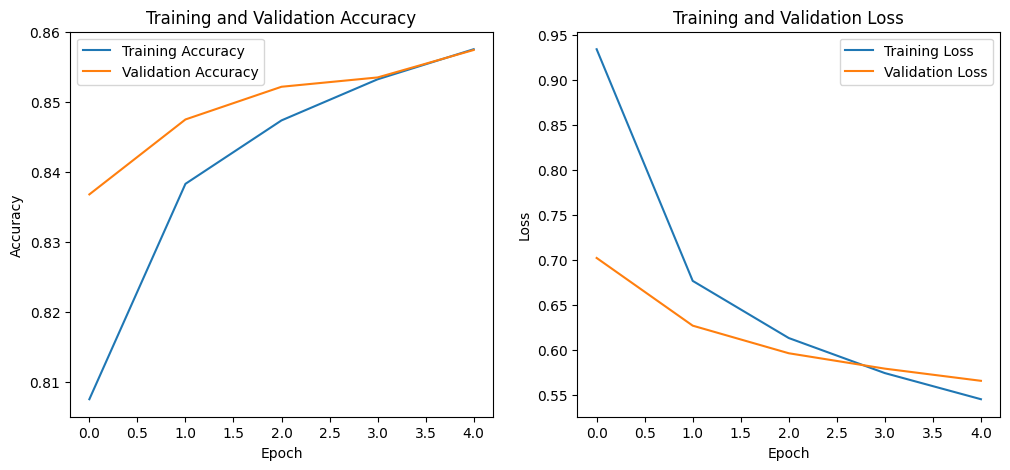

In [ ]:



import torch
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Assuming model, train_dataloader, val_dataloader, device are already defined

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []  # List to store training accuracies
val_accuracies = []    # List to store validation accuracies

def calculate_accuracy(outputs, labels):
    """
    Calculates the accuracy of the model's predictions.
    """
    # Assuming your model outputs logits, and labels are the target indices
    predicted_classes = torch.argmax(outputs.logits, dim=-1)  # Get the class with the highest probability
    correct = (predicted_classes == labels).sum().item()
    total = labels.numel()
    return correct / total

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch['title_input_ids'].to(device)
        attention_mask = batch['title_attention_mask'].to(device)
        labels = batch['ingredient_input_ids'].to(device)  # Assuming this is your target
        decoder_attention_mask = batch['ingredient_attention_mask'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,  # Pass labels here
            decoder_attention_mask=decoder_attention_mask
        )
        loss = outputs.loss
        total_train_loss += loss.item()

        # Calculate training accuracy
        total_train_accuracy += calculate_accuracy(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}")
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Evaluation on the validation set
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['title_input_ids'].to(device)
            attention_mask = batch['title_attention_mask'].to(device)
            labels = batch['ingredient_input_ids'].to(device)
            decoder_attention_mask = batch['ingredient_attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                decoder_attention_mask=decoder_attention_mask
            )
            loss = outputs.loss
            total_val_loss += loss.item()
            total_val_accuracy += calculate_accuracy(outputs, labels)
    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_accuracy = total_val_accuracy / len(val_dataloader)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

print("Training finished!")

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
def generate_ingredients(title):
    model.eval()
    input_ids = tokenizer.encode(title, return_tensors="pt").to(device)
    outputs = model.generate(input_ids)
    decoded_ingredients = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_ingredients

# Let's try a few titles from our dataset
sample_titles = df_small['title'].iloc[[0, 10, 20]].tolist()
print("Generated ingredients:")
for title in sample_titles:
    generated = generate_ingredients(title)
    actual = " ".join(df_small['ingredients_list'].iloc[df_small[df_small['title'] == title].index[0]])
    print(f"Title: {title}")
    print(f"Generated: {generated}")
    print(f"Actual: {actual}")
    print("-" * 30)

Generated ingredients:
Title: No-Bake Nut Cookies
Generated:  race highlight TV fellowpack race annual International@ TVOTA Jub race surgingmodel makeshift soon patterns
Actual: 1 c. firmly packed brown sugar 1/2 c. evaporated milk 1/2 tsp. vanilla 1/2 c. broken nuts (pecans) 2 Tbsp. butter or margarine 3 1/2 c. bite size shredded rice biscuits
------------------------------
Title: Double Cherry Delight
Generated:  race highlight TV fellowpack race annual International@ TVOTA Jub race surgingmodel makeshift soon patterns
Actual: 1 (17 oz.) can dark sweet pitted cherries 1/2 c. ginger ale 1 (6 oz.) pkg. Jell-O cherry flavor gelatin 2 c. boiling water 1/8 tsp. almond extract 1 c. miniature marshmallows
------------------------------
Title: Grandma Hanrath'S Banana Breadfort Collins, Colorado  
Generated:  race management chairman Will TVneau race@ TV specificallypoint race annual International@ TV opens race
Actual: 1 c. sugar 1/2 c. shortening 2 eggs (add one at a time) 1 tsp. salt 2 ts